In [1]:
##################
## Load Imports ##
##################

import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import plotting_helpers
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

np.random.seed(111)

# 1 Bayesian Linear Regression

In this exercise, we will learn about Bayesian inference in linear regression. We consider a simple, one dimensional dataset and a 2-parameter Bayesian linear model and will do the following:

1. Compute the posterior distribution using a numerical method.
2. Compute the posterior using a closed-form expression.
3. Visualize the prior, likelihood, and posterior distributions.
4. Understand the effect of the prior distribution and dataset size on the posterior.
5. Learn to perform predictions using a Bayesian linear model.

We first load imports and prepare the 1D toy dataset for regression.

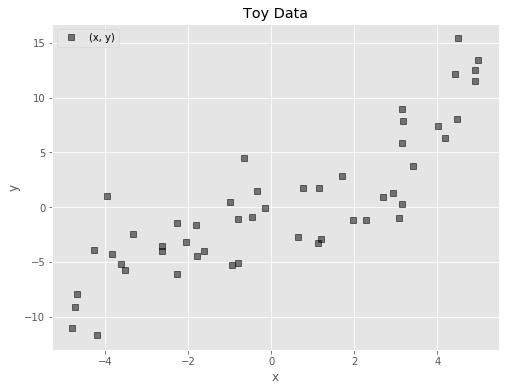

In [2]:
#####################
## Sample Toy Data ##
#####################

def toyData(N, sigma, seed=111):
    np.random.seed(seed)
    x = np.random.uniform(-5, 5, size=N)
    np.random.seed(seed)
    y = 0.1 * x**3 + np.random.normal(0.0, sigma, size=N)
    return x, y

N = 50
sigma = 3.0

x, y = toyData(N, sigma)

# Prepare "design matrix" with a column of ones
X = np.concatenate((x.reshape(-1,1), np.ones(len(x)).reshape(-1,1)),axis=1)

plotting_helpers.plot_toy_data(x, y)

## 1.1 Model Specification
The linear model is given by 
$$y = xw + b + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \tau^{-1}), y \in \mathbb{R}, x \in \mathbb{R}, $$
where $\tau$ is the noise precision, $w_1$ is the slope and $w_0$ is the intercept. Let $\boldsymbol{w} = (w_1,w_0)$ denote the combined parameters. Assume futher that we have $N$ data points $\mathcal{D} = \{(x_n,y_n)\}_{n=1}^N$.

The likelihood of the model is then given by
$$p(\mathcal{D} | \boldsymbol{w})  = \prod_{n=1}^N \mathcal{N}(y_n | x_n w_1 + w_0, \tau^{-1}).$$

A typical choice of prior is a Gaussian prior
$$p(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w} | 0, \lambda^{-1} \boldsymbol{I}),$$
where $\lambda$ is the prior precision.

In [3]:
lam = 1.0 # Prior precision

mu_prior = np.zeros([2])
Sigma_prior = np.eye(2) / lam

prior =  multivariate_normal(mean = mu_prior, 
                             cov = Sigma_prior)

tau = 0.05 # Noise precision

## 1.2 Posterior Inference

Using the prior and the likelihood, we can compute the posterior distribution using Bayes rule

$$p(\boldsymbol{w} | \mathcal{D}) = \frac{p(\boldsymbol{w}) p(\mathcal{D} | \boldsymbol{w})}{p(\mathcal{D})}.$$

### 1.2.1 Computing the Posterior Distribution using a Numerical Method

We will first consider computing the posterior distribution numerically.

A straightforward way to compute the posterior distribution in this case is to compute the marginal probability
$$p( \mathcal{D}) = \int p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}) dw$$
using a numerical method. This requires evaluating the joint density $p(\mathcal{D}, \boldsymbol{w}) = p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w})$ over a large region of $\boldsymbol{w}$ space and then summing over the evaulations:
$$ \int p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}) d\boldsymbol{w} \approx \delta^{d} * \sum_{\boldsymbol{w} \in \boldsymbol{W}_{GRID}}  p(\mathcal{D}|\boldsymbol{w})p(\boldsymbol{w}).$$
Here $\boldsymbol{W}_{GRID}$ is a discretization of the $\boldsymbol{w}$ space into a set of weight vectors, $\delta$ is the spacing betweeen points in the discretization and $d$ is the dimensionality of $\boldsymbol{w}$. Notice that this is a simplification of the trapezoidal rule for numerical integration.

In this linear regression example, $\boldsymbol{w}$ has only two dimensions and it is possible to perform numerical integration. However, this does not work in general; numerical integration is intractable for larger datasets.

### Your Tasks:
* Compute the posterior distribution over model parameters $\boldsymbol{w}$ by implementing the normalization of the joint distribution in ```evaluate_posterior_over_grid```.


In [4]:
### TASKS BEGIN ###
def evaluate_posterior_over_grid(W, prior, tau, X, y, grid_spacing):
    ''' Evaluates the posterior distribution's density function on a grid of values in parameter space. 
    Parameters:
        W: the grid of parameter values flattened into an array of parameter vectors
        prior: a multivariate_normal object that can be used to evaluate prior distribution's density.
        tau: The noise precision of the likelihood function.
        X: dataset features
        y: dataset outputs
        grid_spacing: the spacing between adjacent parameter vectors in the grid.
    '''
    log_prior = np.log(prior.pdf(W))
    f = W @ X.T
    # Evaluate the likelihood of each parameter vector in W
    # N(y|f,Sigma) is algebraically equivelent to N(f|y,Sigma); This allows us to swap the arguments in 
    # multivariate_normal
    log_likelihood = np.log(multivariate_normal(mean = y, cov = np.eye(N) / tau).pdf(f))
    log_joint = log_likelihood + log_prior
    
    ### fill in your code for the log-marginal here ###
    log_marginal = 0
    
    
    log_post = log_joint - log_marginal
    post = np.exp(log_post)
    
    return post
### TASKS END ###

In [5]:
grid_spacing = 0.1
# Create a grid of potential values in parameter space. 
w1, w0 = np.mgrid[-3:3:grid_spacing, -3:3:grid_spacing]
# Compute all combinations of w1 and w2 values from the grid.  
W_grid = np.squeeze(np.dstack((w1, w0)))
# Evaluate the prior's density function at each (w1, w0) pair in the grid.
prior_density = prior.pdf(W_grid)

# Reshape the densities back into a grid.
prior_density = prior_density.reshape((w1.shape[0], w0.shape[0]))
numerical_posterior_density = evaluate_posterior_over_grid(W_grid, prior, tau, X, y, grid_spacing).reshape(w1.shape[0], w0.shape[0])

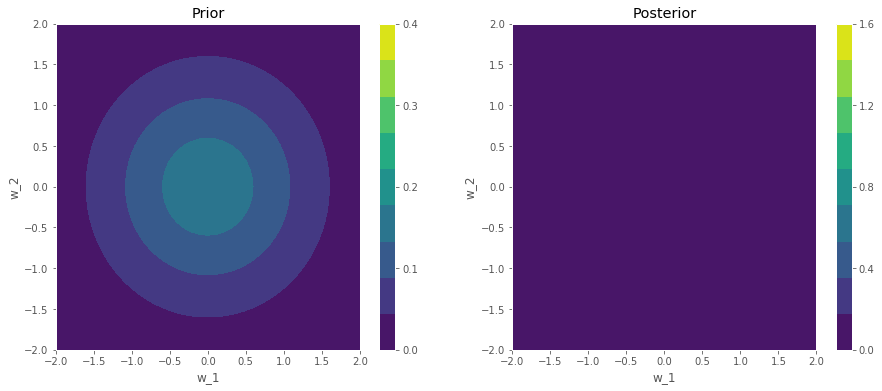

In [6]:
### Visualizing Prior and Posterior Distributions ###
plotting_helpers.lr_visualize_prior_posterior(w0,w1,prior_density,numerical_posterior_density)

### 1.2.2 Computing the Posterior Distribution Algebraically

The Gaussian prior we are using is conjugate to the Gaussian likelihood, which means that the posterior distribution is in the same probability distribution family as the prior. That is, the true posterior distribution is a Gaussian that satisfies:

$$p(\boldsymbol{w} | \mathcal{D}) \propto p(\boldsymbol{\mathcal{D}|w}) * p(\boldsymbol{w})$$

### Your Tasks:
* Calculate and implement the closed-form solution to the posterior distribution $p(\boldsymbol{w} | \mathcal{D})$.

#### SOLUTION
The posterior distribution is Gaussian $p(\boldsymbol{w} | \mathcal{D}) = \mathcal{N}(\boldsymbol{w} | \mu, \Sigma)$, with
$$\Sigma = \left(\lambda I + \tau X^T X\right)^{-1}$$
$$\mu = \tau \Sigma X^T y,$$
where $X$ is the design matrix and $y$ is a vector of all the observations.

In [7]:
### TASKS BEGIN ###
def compute_posterior(mu_prior, Sigma_prior, tau, X, y):
    ''' Computes the true posterior distribution over the model parameters w and returns this distribution as
        a multivariate_normal object.
        Parameters:
            mu_prior: the mean of the prior distribution
            Sigma_prior: the covariance of the prior distribution
            tau: The noise precision of the likelihood function.
            X: dataset features
            y: dataset outputs
    '''
    
    ### fill in your code to compute the posterior here ###
    
    Sigma_posterior = Sigma_prior
    mu_posterior = mu_prior 
    
    return multivariate_normal(mean=mu_posterior, cov=Sigma_posterior)
### TASKS END ###

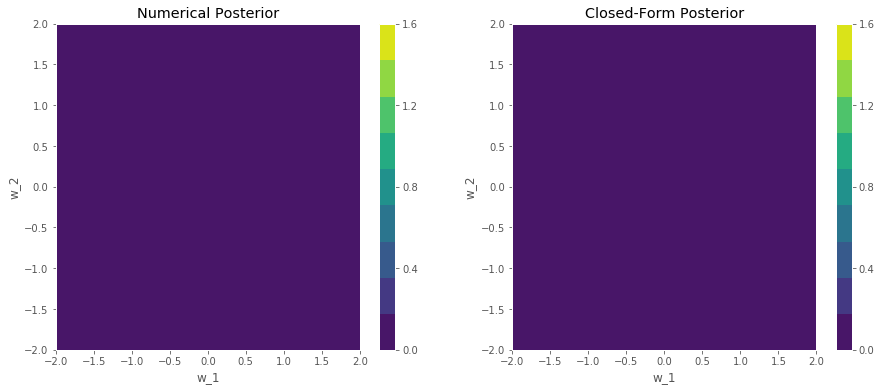

In [8]:
### Plot the Numerical and Closed-Form Solutions for Comparison ###
posterior = compute_posterior(mu_prior, Sigma_prior, tau, X, y)
exact_posterior_density = posterior.pdf(W_grid).reshape(w1.shape[0], w0.shape[0])

plotting_helpers.lr_visualize_numerical_vs_closed_form_posteriors(exact_posterior_density, numerical_posterior_density, w1,w0)


## 1.3 Visualizing Predictions

Next we sample from the prior and the posterior and plot the sampled regression lines.

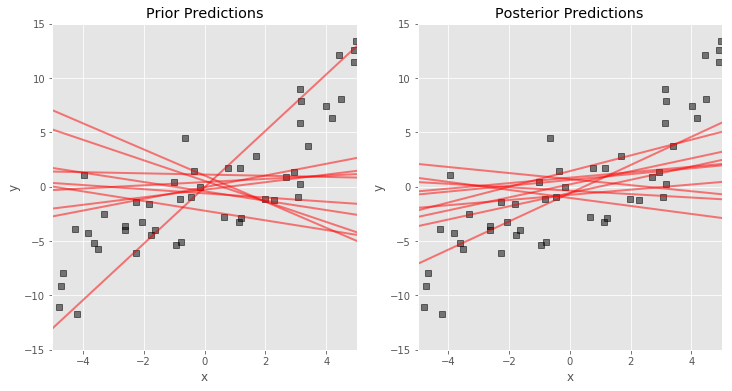

In [9]:
########################
## Sample Predictions ##
########################

num_preds = 10
resolution = 2
x_pred = np.linspace(-5, 5, num=resolution)

def sample_predictions(x_pred, parameter_distribution, num_preds):
    parameter_samples = parameter_distribution.rvs(num_preds)
    y_pred = np.zeros([num_preds, len(x_pred)])
    for i in range(num_preds):
        y_pred[i] = parameter_samples[i,0] * x_pred + parameter_samples[i,1]
    return y_pred

prior_preds = sample_predictions(x_pred, prior, num_preds)
posterior_preds = sample_predictions(x_pred, posterior, num_preds)

######################
## Plot Predictions ##
######################

plotting_helpers.plot_prior_and_posterior_predictions(x, y, x_pred, prior_preds, posterior_preds)

## 1.4 Optional Tasks

### 1.4.1 The Effect of More Data

What effect does adding more data points have on the posterior? Use the widget below to explore the effects of dataset size.

In [10]:
######################
## Interactive Plot ##
######################

def f(N):
    print(N)
    x, y = toyData(N, sigma, seed=111)
    np.random.seed(111)
    X = np.concatenate((x.reshape(-1,1), np.ones(len(x)).reshape(-1,1)),axis=1)
    posterior = compute_posterior(mu_prior, Sigma_prior, tau, X, y)
    prior_preds = sample_predictions(x_pred, prior, num_preds)
    posterior_preds = sample_predictions(x_pred, posterior, num_preds)
    plotting_helpers.plot_prior_and_posterior_predictions(x, y, x_pred, prior_preds, posterior_preds)

interaction = interact(f, N=widgets.IntSlider(min=5,max=100,step=5,value=N,continuous_update=False))


interactive(children=(IntSlider(value=50, continuous_update=False, description='N', min=5, step=5), Output()),…

### 1.4.2 The Predictive Distribution

1. Actually, we don't need to sample from the posterior to obtain predictions.
The predictive distribution 
$$p(y|x,\mathcal{D}) = \int p(y | x, \boldsymbol{w}) p(\boldsymbol{w} | \mathcal{D}) d\boldsymbol{w}$$
can be computed in closed-form. How does the predictive distribution relate to the sampled predictions above?
1. Calculate the predictive distribution $p(y|x,\mathcal{D})$.

### 1.5.3 Fully Bayesian Linear Regression

1. Suppose we want to treat $\tau$ as an unknown variable and would like to compute the posterior over $(\boldsymbol{w}, \tau )$. What is the conjugate prior for the combined parameters ($\boldsymbol{w}$, $\tau$)? How would this model differ from the case above where we considered $\tau$ to be constant?